# RUN THESE CELLS ON GOOGLE COLAB

In [1]:
!pip install ultralytics roboflow -q

# Check GPU availability
!nvidia-smi

# Import Libraries
import os
from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import Image, display

# Check if ultralytics is installed correctly
import ultralytics
ultralytics.checks()

# Set Working Directory
HOME = os.getcwd()
print(f"\nCurrent working directory: {HOME}")

Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.9/112.6 GB disk)

Current working directory: /content


In [2]:
# --- CHANGES ---
ROBOFLOW_API_KEY = "XDKE4WlCgR2j0tiYMb3m"
WORKSPACE_ID = "motorbike-rules-violation-detection"  # Workspace's ID in Roboflow
PROJECT_ID = "traffic-violation-detection-xab49"    # Project's ID in Roboflow
VERSION_NUMBER = 13 # Version number of the dataset to download

# --- END CHANGES ---

# Download dataset from Roboflow
try:
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    project = rf.workspace(WORKSPACE_ID).project(PROJECT_ID)
    dataset = project.version(VERSION_NUMBER).download("yolov8")
    DATASET_PATH = dataset.location
    print(f"Dataset was downloaded at: {DATASET_PATH}")
    # Display dataset information
    %cat {DATASET_PATH}/data.yaml
except Exception as e:
    print(f"Error: {e}")
    print("Please check API Key and IDs.")
    DATASET_PATH = None

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Traffic-Violation-Detection-13 in yolov8:: 100%|██████████| 2090/2090 [00:00<00:00, 3420.91it/s]


Dataset was downloaded at: /content/Traffic-Violation-Detection-13
names:
- Bus
- Car
- Motor_Wrong_Lane
nc: 3
roboflow:
  license: CC BY 4.0
  project: traffic-violation-detection-xab49
  url: https://universe.roboflow.com/motorbike-rules-violation-detection/traffic-violation-detection-xab49/dataset/13
  version: 13
  workspace: motorbike-rules-violation-detection
test: ../test/images
train: ../train/images
val: ../valid/images


In [3]:
# Train the YOLOv8 model using the downloaded dataset.

if DATASET_PATH:
    # Train YOLOv8 Model
    !yolo task=detect mode=train \
    model='yolov8m.pt' \
    data='{DATASET_PATH}/data.yaml' \
    epochs=100 \
    imgsz=640 \
    plots=True \
    project='yolov8_training' \
    name='run1'
else:
    print("Dataset not found.")

100% 49.7M/49.7M [00:00<00:00, 303MB/s]
New https://pypi.org/project/ultralytics/8.3.167 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Traffic-Violation-Detection-13/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=F

In [4]:
# Copy best.pt to my_model.pt after training
import shutil, os

best_weight_path = "yolov8_training/run1/weights/best.pt"
custom_weight_path = "my_model.pt"

if os.path.exists(best_weight_path):
    shutil.copy(best_weight_path, custom_weight_path)
    print(f"Copied to {custom_weight_path}")
else:
    print("best.pt not found!")

Copied to my_model.pt


In [6]:
# Validate the trained YOLOv8 model using the best weights saved during training.

# Check if the best weights file exists
path_to_best_weights = 'my_model.pt'

if os.path.exists(path_to_best_weights):
    !yolo task=detect mode=val \
    model='{path_to_best_weights}' \
    data='{DATASET_PATH}/data.yaml'
else:
    print("Cannot find 'my_model.pt'.")

Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1803.1±622.1 MB/s, size: 41.8 KB)
val: Scanning /content/Traffic-Violation-Detection-13/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100% 43/43 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10, len(boxes) = 1206. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:04<00:00,  1.47s/it]
                   all         43       1206      0.944      0.898       0.97      0.797
                   Bus          2          2       0.91          1      0.995      0.946
                   Car         41   

In [7]:
# Run predictions on the test images using the best weights saved during training.

# path_to_best_weights = 'yolov8_training/run1/weights/my_model.pt'
# Check if the best weights file exists

if os.path.exists(path_to_best_weights):
    !yolo task=detect mode=predict \
    model='{path_to_best_weights}' \
    conf=0.25 \
    source='{DATASET_PATH}/test/images' \
    save=True
else:
    print("The weight file 'my_model.pt' was not found for running inference.")

Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs

image 1/30 /content/Traffic-Violation-Detection-13/test/images/IMG_0402_MOV-0000_jpg.rf.384a9518be6d99fe3e80ef802e07f7bb.jpg: 384x640 12 Cars, 100 Motor_Wrong_Lanes, 57.6ms
image 2/30 /content/Traffic-Violation-Detection-13/test/images/IMG_0402_MOV-0001_jpg.rf.d0ff258f2a0988626cf6181b54b07980.jpg: 384x640 11 Cars, 100 Motor_Wrong_Lanes, 25.1ms
image 3/30 /content/Traffic-Violation-Detection-13/test/images/IMG_0402_MOV-0002_jpg.rf.e09508155ff1c9c8e527f3a2db5192f6.jpg: 384x640 11 Cars, 108 Motor_Wrong_Lanes, 25.1ms
image 4/30 /content/Traffic-Violation-Detection-13/test/images/IMG_0402_MOV-0003_jpg.rf.7918d68f48276564f782aa94707946dc.jpg: 384x640 12 Cars, 101 Motor_Wrong_Lanes, 25.1ms
image 5/30 /content/Traffic-Violation-Detection-13/test/images/IMG_0402_MOV-0022_jpg.rf.548c71e0e41b1d88c1ea5b2c6a2c7b15.jpg: 384x640 14 Cars,

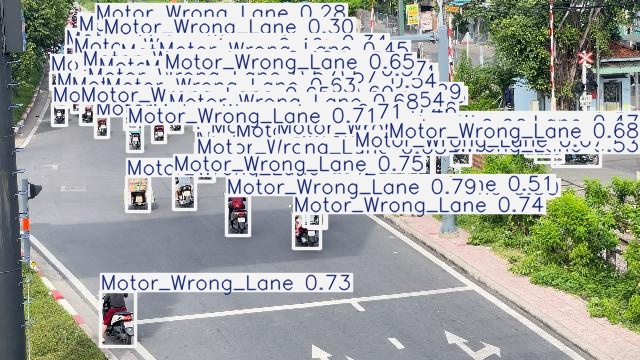

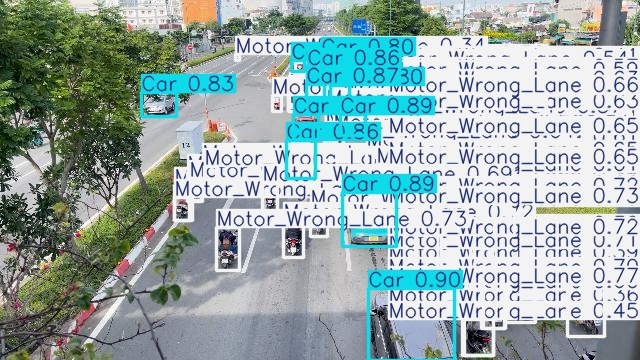

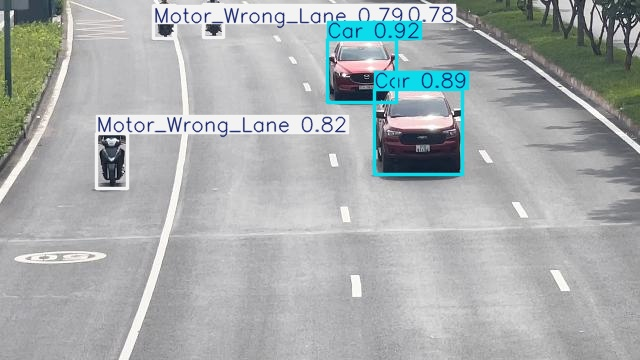

In [8]:
# Display the prediction results from the latest prediction folder.

import glob

# Take the latest prediction folder
predict_folders = glob.glob('runs/detect/predict*')
latest_predict_folder = sorted(predict_folders, key=os.path.getmtime)[-1] if predict_folders else None

if latest_predict_folder:
    # Display the first 3 images from the latest prediction folder
    for image_file in glob.glob(f'{latest_predict_folder}/*.jpg')[:3]:
        display(Image(filename=image_file, width=600))
else:
    print("Prediction result folder not found.")